In [1]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

In [2]:
df = pd.read_parquet('german_credit_data.parquet').drop('Unnamed: 0', axis=1)

In [3]:
df = df.rename(columns = {
    'Sex': 'Gender',
    'Saving accounts': 'Saving_acc',
    'Checking account': 'Checking_acc',
    'Credit amount': 'Credit_mnt',
})

df.Gender = df.Gender.apply(lambda x: 1 if x == 'male' else 0)
df.Risk = df.Risk.apply(lambda x: 1 if x == 'good' else 0)

df.Saving_acc = df.Saving_acc.map({
    None: 'none',
    'little': 'low',
    'moderate': 'medium',
    'quite rich': 'high',
    'rich': 'high'
})
df.Checking_acc = df.Checking_acc.map({
    None: 'none',
    'little': 'low',
    'moderate': 'medium',
    'rich': 'high'
})

df.Purpose = df.Purpose.str.replace('/', '_').str.replace(' ', '_')

In [4]:
def categorize(df, feature):
    cutted = pd.qcut(df[feature], 3, ['low', 'medium', 'high'])
    categorized = pd.DataFrame(cutted)
    df[feature] = categorized
    return df

In [5]:
def get_woe_map(df, feature, target):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad
        
    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Distribution Good'] = (
        (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    )
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})


    data = data.sort_values(by='WoE')
    data.index = range(len(data.index))
    data = data.set_index('Value')['WoE'].to_dict()
    
    return data

In [6]:
def woe_map_it(df, feature, target):
    df[feature] = df[feature].map( get_woe_map(df, feature, target) )

In [7]:
y = df.Risk
X = df.loc[:, df.columns != 'Risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
X_train['Risk'] = y_train
df_train = X_train

X_test['Risk'] = y_test
df_test = X_test

In [9]:
def categorize_and_map_df(df):
    categorize(df, 'Age')
    categorize(df, 'Credit_mnt')
    categorize(df, 'Duration')

    woe_map_it(df, 'Age', 'Risk')
    woe_map_it(df, 'Job', 'Risk')
    woe_map_it(df, 'Housing', 'Risk')
    woe_map_it(df, 'Saving_acc', 'Risk')
    woe_map_it(df, 'Checking_acc', 'Risk')
    woe_map_it(df, 'Credit_mnt', 'Risk')
    woe_map_it(df, 'Duration', 'Risk')
    woe_map_it(df, 'Purpose', 'Risk')

In [10]:
categorize_and_map_df(df_train)
categorize_and_map_df(df_test)

/home/mauer/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
y_train = df_train.Risk
X_train = df_train.loc[:, df.columns != 'Risk']

y_test = df_test.Risk
X_test = df_test.loc[:, df.columns != 'Risk']

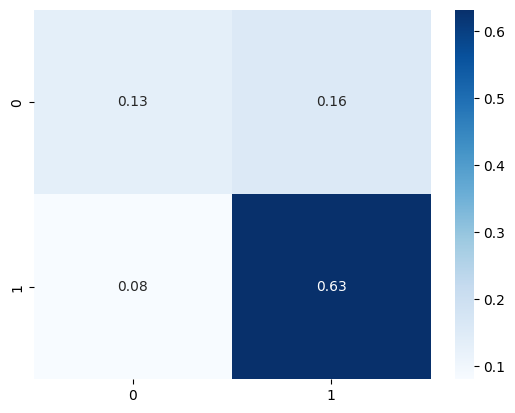

Accuracy score:  0.76
F1 score:        0.84
Precision score: 0.80
Recall score:    0.89


In [21]:
model = LogisticRegression()

model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

sns.heatmap(
    metrics.confusion_matrix(y_test, y_predicted, normalize='all'),
    cmap='Blues', annot=True, fmt='.2f'
)
plt.show()

print('Accuracy score:  {:.2f}'.format( metrics.accuracy_score(y_test, y_predicted) ))
print('F1 score:        {:.2f}'.format( metrics.f1_score(y_test, y_predicted) ))
print('Precision score: {:.2f}'.format( metrics.precision_score(y_test, y_predicted) ))
print('Recall score:    {:.2f}'.format( metrics.recall_score(y_test, y_predicted) ))